# ML algorithm for pattern classification
This notebook contains the definitions and training pipeline of the machine learning algorithms applied in the paper.
For each algorithm, a model will be created with the same hyperparameters as the ones declared in the paper (defaults hyperparameters of <code>sklearn</code>).

Said model will be trained and tested on the splits already provided before the beginning of the SeqScout procedure. In this way, we can have a score that is as much as comparable as possible with the values reported by the paper.


Then, an hyperparameter search will be conducted on the models via cross validation on the training split. The best performing model will be again trained on the full train set and tested on test set, in order to compare it to the default model.
Each model will be compared on accuracy, precision and recall. Moreover, the confusion matrix for each best performing model will be produced.

## Major differences
Aside from the machine learning library employed, the presented algorithms differ from the original paper in a couple of aspects:
- They use the OneVsRest classifier for each model, while we use directly the multiclass classifier (except for the LinearSVC). This allows to save time on the model training and consequently on the hyperparameter search.
- The results will be computed on a single test split equal to a fifth of the original dataset. This split follows the same division employed for k-fold evaluation in the original paper. This choice was made considering the high overhead required when computing the patterns, as well as the absence of an easy procedure to extract a stratified split of the dataset within PySpark.
- As SVM model, PySpark offers only the LinearSVC, thus it will be used in place of SVC. In this case, the default parameter considered for the baseline model will be the ones provided by PySpark.

## Library imports
NB: The default package of PySpark does not include the algorithm for the XGBoost. The required libraries are installed through the bootstrap script.

In [1]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC, OneVsRest, NaiveBayes
from pyspark.ml.classification import DecisionTreeClassificationModel, RandomForestClassificationModel, OneVsRestModel, NaiveBayesModel
from pyspark.mllib.tree import RandomForestModel, DecisionTreeModel
from pyspark.ml.tuning import CrossValidatorModel
from xgboost.spark import SparkXGBClassifier, SparkXGBClassifierModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from utils import load_df
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.stat import Summarizer
from IPython.display import Image

## Dataset loading, function definitions and brief preliminary analysis
As first step, we load the already encoded dataframes for training and testing the algorithms. We also set the path where the models will be saved as well as the random seed for reproducibility.

In [48]:
spark = SparkSession.builder.appName("RocketLeagueL").getOrCreate()

base_path = 'hdfs://hdmaster:9000/user/ubuntu/'
path = base_path + "dataset/"

model_path = base_path + 'models/'
train = load_df(path, "encoded_df", spark)
test = load_df(path, "encoded_test", spark)
seed = 42


Cells for the loading of checkpoints of the trained models are then added (The tuned models take some time to be loaded).

In [ ]:
# loads base models
print("Loading decision tree...")
dtcf = DecisionTreeClassificationModel.load(model_path + 'decision_tree/base')
print("Loading random forest...")
rfcf = RandomForestClassificationModel.load(model_path + 'random_forest/base')
print("Loading XGBoost...")
xgbf = SparkXGBClassifierModel.load(model_path + 'xgb/base')
print("Loading SVM...")
svmf = OneVsRestModel.load(model_path + 'svm/base')
print("Loading Naive Bayes...")
nbf = NaiveBayesModel.load(model_path + 'nb/base')

In [ ]:
# loads tuned models (takes some time)
print("Loading tuned decision tree...")
dtc_cv_model = CrossValidatorModel.load(model_path + 'decision_tree/hyperParameterTuned')
print("Loading tuned random forest...")
rfc_cv_model = CrossValidatorModel.load(model_path + 'random_forest/hyperParameterTuned')
print("Loading tuned XGBoost...")
xgb_cv_model = CrossValidatorModel.load(model_path + 'xgb/hyperParameterTunedFinal')
print("Loading tuned SVM...")
svm_cv_model = CrossValidatorModel.load(model_path + 'svm/hyperParameterTuned')
print("Loading tuned Naive Bayes...")
nb_cv_model = CrossValidatorModel.load(model_path + 'nb/hyperParameterTuned')

Then, a couple of function are defined in order to automatically compute the evaluation metrics and to print them together with the confusion matrix. Among those, a function to compute unweighted recall is added, as the weighted version provided by the MulticlassMetrics class is computed analitically in the same way as accuracy and returns the same value. Moreover, to improve the readability of the produced graph, the list of labels for the classes is also added.

In [39]:
ordered_labels = ['Noise', 
                      'Ceiling Shot', 
                      'Power Shot', 
                      'Waving Dash',
                      'Air Dribbling',
                      'Front Flick',
                      'Musty Flick']

def compute_metrics(prediction_df):
    """
    Function computing some metrics for the evaluation of the machine learning models. It uses MulticlassMetrics from
    the pyspark library.
    params:
        prediction_df: pyspark dataframe containing at least a prediction column called "prediction"
                       amd a class colimn called "class"
    returns:
        a MulticlassMetrics object containing the metrics about the prediction_df
    """
    rdd_pred = prediction_df.select("prediction", "class").withColumn("class",F.col('class').cast(FloatType())).orderBy('class').rdd.map(tuple)
    metrics = MulticlassMetrics(rdd_pred)
    return metrics

def compute_mean_recall(mc_metrics):
    """
    Function computing the mean unweighted recall metric (True Positives/ TP + False Negatives) for a multiclass
    classification problem. It requires a MulticlassMetrics object from which the confusion matrix used for the computation.
    params:
        mc_metrics: MulticlassMetrics object containing the statistics about the prediction of a model over a data set
    returns:
        The unweighted average of recall of the different classes
    """
    confusion_matrix = mc_metrics.confusionMatrix().toArray()
    # The true positives are in the diagonal of the matrix.
    # The total of the the examples having class with index i is the sum of the values over the row i
    return (confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)).mean()
    

def print_metrics(prediction_df, ordered_labels=ordered_labels):
    """
    Function printing some metrics for evaluation, as well as the confusion matrix given a pyspark dataframe
    with ground truth labels and predictions. The confusion matrix is printed with values normalized on the true and false
    positives (precision)
    params:
        prediction_df: pyspark dataframe containing at least a prediction column
                       called "prediction" and a class column called "class"
        ordered_labels: list of labels whose position order corresponds to the position order of the corresponding class values
    """
    metrics = compute_metrics(prediction_df)
    print("Accuracy: ")
    print(f'%.3f'%metrics.accuracy)
    print("Weighted precision: ")
    print(f'%.3f'%metrics.weightedPrecision)
    print("Unweighted recall: ")
    print(f'%.3f'%compute_mean_recall(metrics))
    cm = metrics.confusionMatrix().toArray()
    cm = cm / (cm.sum(axis=0))

    sns.heatmap(cm, annot=True, xticklabels=ordered_labels, yticklabels=ordered_labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    

### Classes distribution
In the following barplots we verify again that the class distribution is equal between the training and the test split, as a stratified one was performed during the pre-processing procedure. The only classes that are slightly skewed in the test set w.r.t. the trianing one are the "Air Dribbling" and "Front Flick" classes.

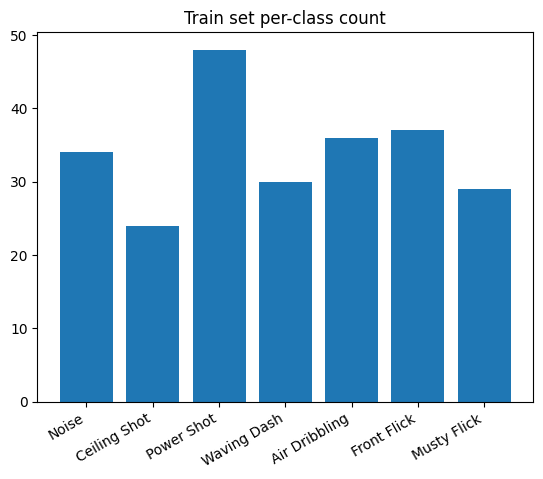

In [87]:
# getting per class counts
hist_data_train = train.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Train set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_train], tick_label=ordered_labels)
plt.show()

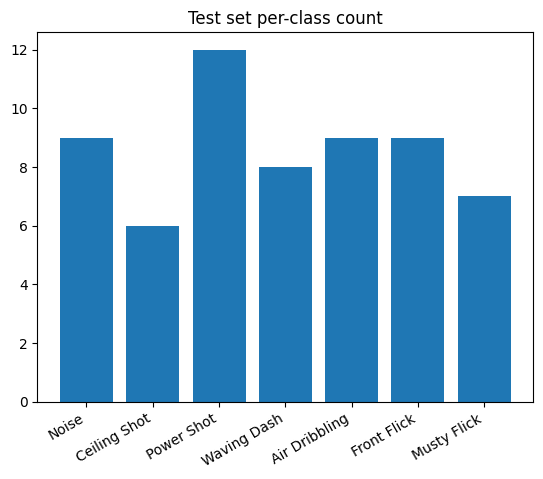

In [86]:
hist_data_test = test.groupBy('class').count().sort('class').collect()
# setting label alignment and rotation
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plotting the values
plt.title("Test set per-class count")
plt.bar(np.arange(len(ordered_labels)),[i['count'] for i in hist_data_test], tick_label=ordered_labels)
plt.show()

### Features distribution
Then, since at this point the dataset is mainly constituted of binary features indicating whether a specific pattern has been found in a sequence, we can see how these pattern effectively encode the charateristics of a class. 

In order to do so, we group the DataFrame by class, sum over the values of each binary feature, normalize these values by column and then show the results as a heatmap. 

We should expect the heatmap to show the "main diagonal" to have higher values (shown with brighter colors) since the features were added by following the order induced by the values used to indicate the classes (e.g. first 20 features/patterns refers to the "Ceiling Shot" (class 1), the following 20 refers to "Power Shot" (class 2), etc.). This also follows from the fact that, as shown in the reference paper, the *seq scout* algorithm is able to extract discriminative patterns from the given sequences.

In [78]:
def show_heatmap(dataframe, c="class", feats="features", ordered_labels=ordered_labels):
    """
    Function printing the heatmap of a given binary dataframe. In particular, the function groups the rows by the column
    c, sums the values in feats and then turns them into percentage.
    params:
        dataframe: input dataframe containing the information to be aggregated
        c: column name to be used to group the records
        feats: name of the column to be aggregated
        ordered_labels: list of ordered names to be given to the rows of the heatmap
    """
    # summing the values after grouping by class
    summarized_df = dataframe.groupBy(c).agg(Summarizer.sum(F.col(feats)).alias("per_c_sum")).orderBy(c)\
                    .select("per_c_sum")
    norm = summarized_df.agg(Summarizer.sum(summarized_df.per_c_sum).alias("norm")).collect()[0].asDict()["norm"] 
    # if there is a pattern without support, we fix the normalization coefficient to avoid division by 0
    if norm.numNonzeros() != len(norm):
        norm = norm.toArray()
        norm[norm == 0.] = 1
    summarized_df = summarized_df.collect()
    summarized_df = [summarized_df[i].asDict()["per_c_sum"]/norm for i in range(len(summarized_df))]
    fig, ax = plt.subplots(figsize=(25,3)) 
    sns.heatmap(summarized_df, yticklabels=ordered_labels, ax=ax)
    plt.xlabel("features")
    plt.show()

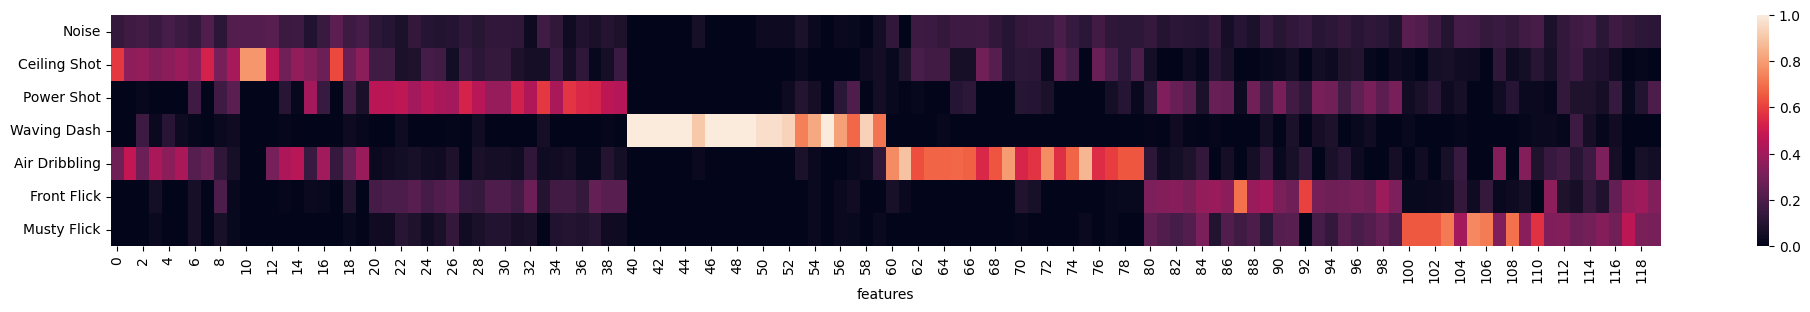

In [79]:
show_heatmap(train)

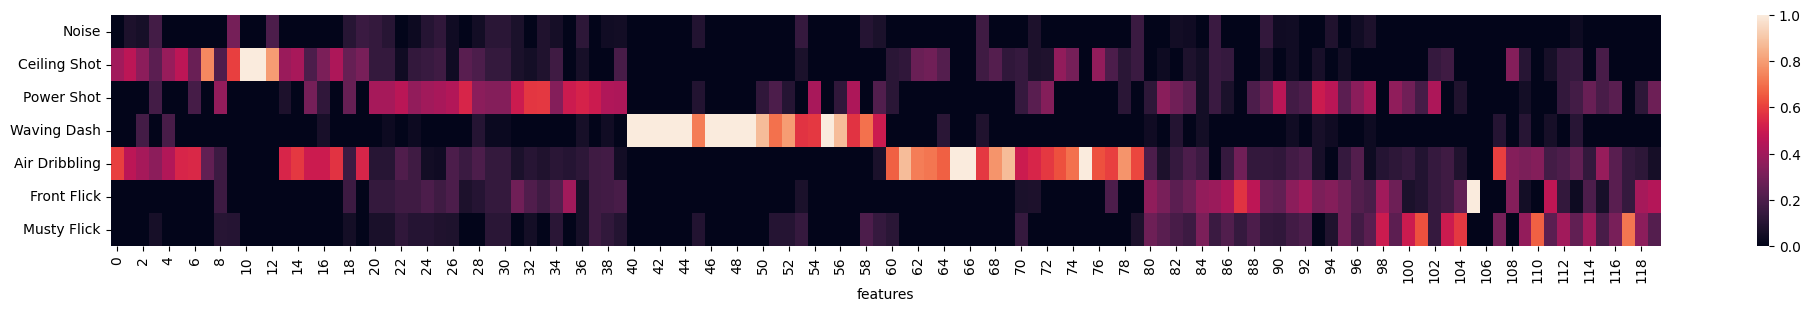

In [80]:
show_heatmap(test)

The general trend follows what we were expecting, having brighter colors on the main diagonal. Said diagonal is "sharper" on the training set w.r.t to the test split as the patterns were extracted directly from that part of the dataset. 

We can also observe that the first row, referring to the noise sequences, incorporates most of the patterns but never in a distinctive way, also because it was excluded from the pattern mining procedure.

Finally we can also observe that some patterns can consistently encode shots that do not belong to the same class for which they were extracted for:
- Patterns for "Ceiling shot" found in "Air Dribbling" (and viceversa);
- Patterns for "Power shot" found in "Front Flick" (and viceversa);
- Patterns for "Front flick" found in "Musty Flick" (and viceversa, even if less prominent).

This can be explained considering that said pairs of shots have similar setups and/or are similar in nature. With the same background knowledge on the game, we can explain why the patterns for the "Waving Dash" pattern are more distinctive. In fact, differently from the other tricks, It is the only one that is purely used for movement rather than to score a point.

In conclusion, even if the analysis is somewhat reductive as it doesn't take into account the correlations between the patterns, it will be still useful to analyze the results of the models.

# Machine Learning models training and tuning
As previously said, we start by creating a base model which will also serve as comparison.
Then we proceed to apply a grid search with a 4-fold cross validation to find the best set of hyperparameters for the models.
The models are automatically re-trained on the full training at the end of the CV procedure.

## Decision Tree

To reproduce the results obtained with default Scikit Learn parameters, we set the <code>max_depth</code> parameter to 30 which is the maximum supported by PySpark and should act as "unconstrained" depth.

In [8]:
dtc = DecisionTreeClassifier(maxDepth=30, seed=seed, featuresCol='features', labelCol='class')
# apparently 30 is the currently supported maximum depth for pyspark

# fitting the model
dtcf = dtc.fit(train)
# saving
dtcf.save(model_path + 'decision_tree/base')

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       0.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.733
Weighted precision: 
0.823
Unweighted recall: 
0.713


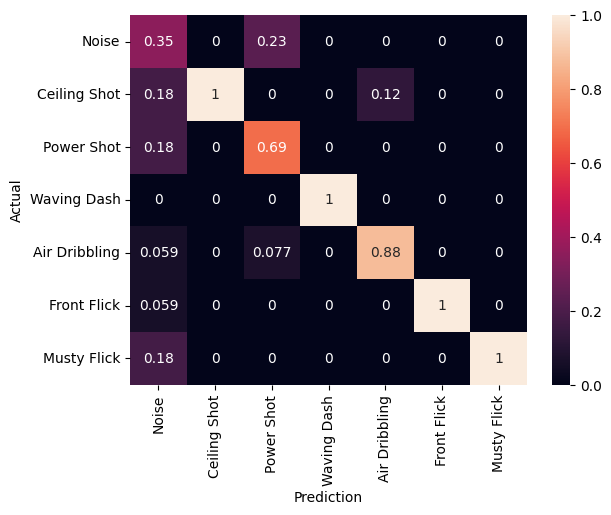

In [42]:
# getting predictions
dtc_predictions = dtcf.transform(test)
dtc_predictions.select("prediction", "class").show(15)
print_metrics(dtc_predictions)

In the case of the Decision tree we optimize w.r.t the following hyperparameters:
- Impurity criterion: Gini index or entropy;
- Maximum depth of the tree: between 3 and 14. Since the features are binary, the value 3 is chosen as it allows to create a tree with at least 8 different labeled leaf nodes, which is slightly above the number of classes (7). At the same time, the value 14 is chosen as it is less than half the maximum allowed depth and slightly above the value of depth achieved by the base model (11);
- Minimum instances in a leaf node: in {1, 2, 3, 4, 5};
- Minimum gain in the impurity criterion to apply the split: in [0.1, 1] with steps of 0.1.

In [65]:
# base model
dtc_cv = DecisionTreeClassifier(featuresCol='features', labelCol='class',seed=seed)
# creating the grid
dtc_param_grid = ParamGridBuilder()\
                .addGrid(dtc_cv.impurity, ['gini', 'entropy'])\
                .addGrid(dtc_cv.maxDepth, [i+1 for i in range(3,15)])\
                .addGrid(dtc_cv.minInstancesPerNode, [i+1 for i in range(5)])\
                .addGrid(dtc_cv.minInfoGain, [0.1*i for i in range(11)]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

dtc_cross_val = CrossValidator(estimator=dtc_cv,
                              estimatorParamMaps=dtc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [7]:
# fitting and tuning
dtc_cv_model = dtc_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [45]:
print("Best parameters:")
print({k.name : v for (k,v) in dtc_cv_model.getEstimatorParamMaps()[np.argmax(dtc_cv_model.avgMetrics)].items()})
dtc_cv_model.save(model_path+"decision_tree/hyperParameterTuned")

Best parameters:
{'minInfoGain': 0.2, 'minInstancesPerNode': 2, 'impurity': 'entropy', 'maxDepth': 7}


...And the results.

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.800
Weighted precision: 
0.846
Unweighted recall: 
0.787


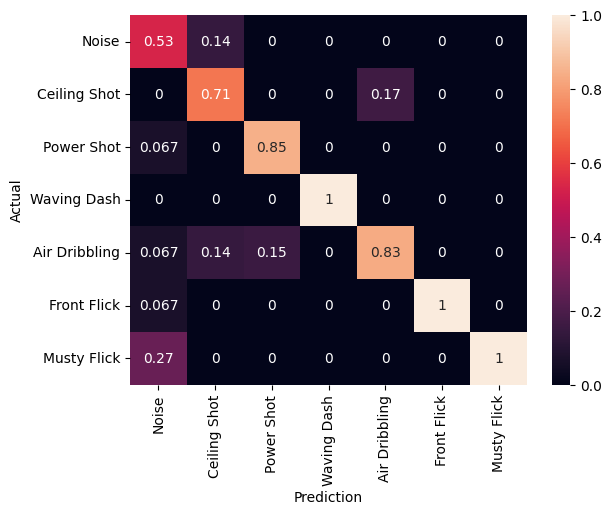

In [43]:
dtc_best_pred = dtc_cv_model.transform(test)
dtc_best_pred.select("prediction", 'class').show(15)
print_metrics(dtc_best_pred)

The tuned model has increased general performances w.r.t the base one, recording a ~+6.7% on accuracy, a ~+2.3% on precision and a +7.4% on recall.

Looking at the confusion matrixes, we can observe that:
- Both models perfectly classify the "Waving Dash" class as expected from the observation of the features distribution. In fact, its the only class with more "unique" patterns w.r.t. the others extracted;
- The tuned model can more precisely classify the "Noise" and "Power Shot" classes which probably is the main reason why the aggregated performances are higher if compared with the base model. On the other side, it tends to classify "Musty flick" more as "Noise" more frequently;
- In the tuned model there is more confusion between "Air Dribbling" and "Ceiling shot" and "Power shot" when compared with the the base model. This confusion can still be explained by the way the test set is encoded ("Air Dribbling" is encoded more frequently with patterns of "Power shot" in the test set) and the observations made from the feature distribution. 

## Random Forest

In [ ]:
rfc = RandomForestClassifier(featuresCol='features',
                             labelCol='class',
                             featureSubsetStrategy='sqrt',
                             maxDepth=30,
                             numTrees=100,
                             seed=seed)
#fitting the model
rfcf = rfc.fit(train)
# saving
rfcf.save(model_path+"random_forest/base")

23/10/01 20:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1381.0 KiB
+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    6|       6.0|
|    6|       6.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows

23/10/01 20:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1383.0 KiB
23/10/01 20:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1384.6 KiB
23/10/01 20:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1392.9 KiB
Accuracy: 
23/10/01 20:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1403.3 KiB
0.850
Weighted precision: 
0.874
Unweighted recall: 
0.828


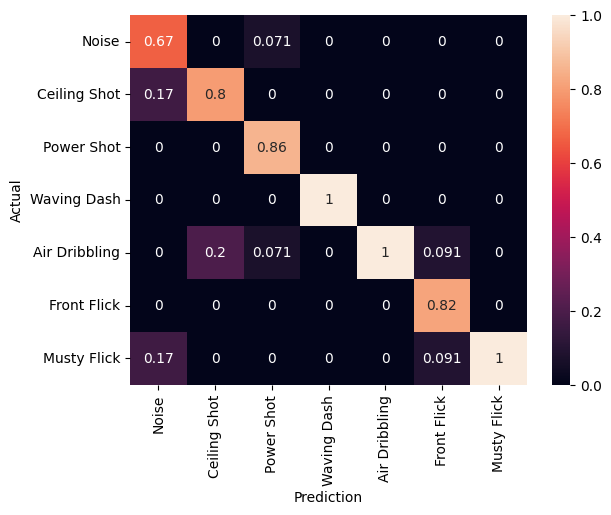

In [44]:
# getting predictions
rfc_predictions = rfcf.transform(test)
rfc_predictions.select('class', 'prediction').show(15)
print_metrics(rfc_predictions)

For the Random Forest we build the grid on the following parameters:
- Impurity measure: Gini index or entropy;
- Maximum depth of the trees: between 3 and 9. The range is reduced w.r.t. the decision tree after checking that the best <code>max_depth</code> for the tree is 7;
- Minimum instances in a leaf node: between 1 and 3. Also here the range for the same reason as above;
- Minimum information gain for the split: in {0.2, 0.4, 0.6, 0.8, 1};
- Strategy for the selection of features when building a new tree: between all the available ones - all, one third of the total, square root of the total, base 2 logarithm of the total;
- Number of trees in the forest: in {25, 50, 75, 100, 125, 150, 175, 200};
- Subsampling percentage to be applied on the dataset when building a tree: in {0.2, 0.4, 0.6, 0.8, 1}

In [12]:
# base model
rfc_cv = RandomForestClassifier(featuresCol='features', labelCol='class',seed=seed)

# in hyperparameters optimization we are considering only the automatic feature selection methods
rfc_param_grid = ParamGridBuilder()\
                .addGrid(rfc_cv.impurity, ['gini', 'entropy'])\
                .addGrid(rfc_cv.maxDepth, [i+1 for i in range(3,10)])\
                .addGrid(rfc_cv.minInstancesPerNode, [i+1 for i in range(3)])\
                .addGrid(rfc_cv.minInfoGain, [0.2*i for i in range(1,6)])\
                .addGrid(rfc_cv.featureSubsetStrategy, ['sqrt', 'all', 'log2', 'onethird'])\
                .addGrid(rfc_cv.numTrees, [25*i for i in range(1,9)])\
                .addGrid(rfc_cv.subsamplingRate, [0.2*i for i in range(1, 6)]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')


rfc_cross_val = CrossValidator(estimator=rfc_cv,
                              estimatorParamMaps=rfc_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
# fitting and tuning
rfc_cv_model = rfc_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [46]:
print("Best parameters:")
print({k.name : v for (k,v) in rfc_cv_model.getEstimatorParamMaps()[np.argmax(rfc_cv_model.avgMetrics)].items()})
rfc_cv_model.save(model_path+"random_forest/hyperParameterTuned")

Best parameters:
{'featureSubsetStrategy': 'onethird', 'numTrees': 25, 'maxDepth': 7, 'impurity': 'entropy', 'minInfoGain': 0.2, 'minInstancesPerNode': 1, 'subsamplingRate': 0.8}


...And the results.

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.883
Weighted precision: 
0.897
Unweighted recall: 
0.875


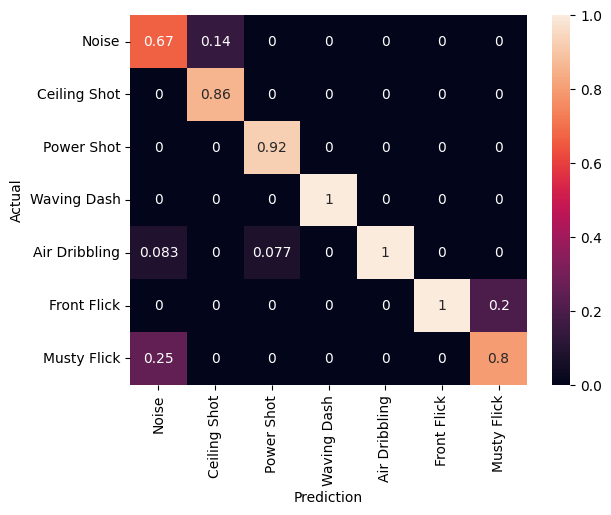

In [45]:
rfc_best_pred = rfc_cv_model.transform(test)
rfc_best_pred.select("prediction", 'class').show(15)
print_metrics(rfc_best_pred)

Again, the tuned model shows improvements on all the metrics w.r.t. the base one, which already represented a good starting point. The tuned model records an increase of ~+3.3% in accuracy, of ~+2.3% in precision and ~+4.7% on recall. The Random Tree can overcome the similarity between classes (e.g. "Air Dribbling" - "Ceiling shot") better than the other models as it can more easily consider the different correlations between features thanks to the usage of the ensamble technique.

In particular, we can see:
- Higher precision on "Ceiling Shot", "Power Shot" and "Front Flick";
- There's still some error in classfying some classes as "Noise";
- There's less precision on "Musty Flick", as it is confused with the similar class "Front Flick";
- There is still some slight confusion on "Power shot" and "Air Dribbling" due to the way the patterns encoded the test set.


## XGBoost

In [17]:
xgb = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         num_workers=2,
                         random_state=seed)
# fitting the model
xgbf = xgb.fit(train)
# saving the model
xgbf.save(model_path+'xgb/base')

2023-09-17 20:56:02,491 INFO XGBoost-PySpark: _fit Running xgboost-2.0.0 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'max_depth': 7, 'random_state': 42, 'num_class': 7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[20:56:03] task 0 got new rank 0                                    (0 + 1) / 1]
2023-09-17 20:56:04,981 INFO XGBoost-PySpark: _fit Finished xgboost training!   


2023-09-30 19:21:03,245 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       0.0|
|    6|       6.0|
|    6|       6.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows



2023-09-30 19:21:04,109 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-09-30 19:21:04,217 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.833
Weighted precision: 
0.899
Weighted recall: 
0.833


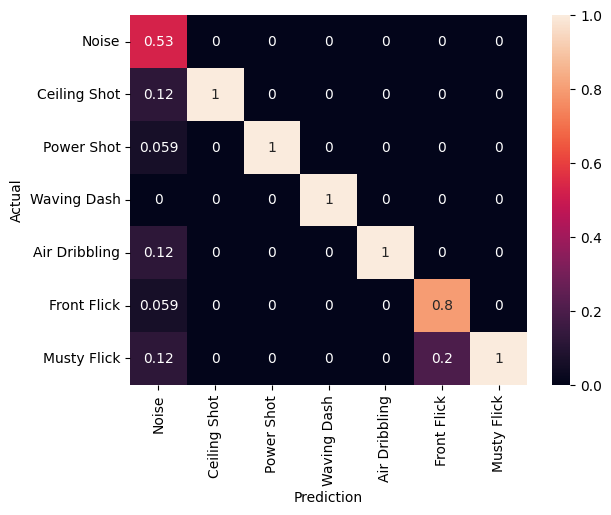

In [101]:
# getting the results
xgb_predictions = xgbf.transform(test)
xgb_predictions.select('class', 'prediction').show(15)
print_metrics(xgb_predictions)

Due to the large hyperparameter space of XGBoost, the search was intially focused on the more important parameters to be tuned.
The values were chosen based on previous results on the Decision Tree (<code>max_depth</code>) or considering this [article](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/) as a reference. Also the set of hyperparameters is restricted due to the overhead required for training.
The tuned parameters are:
- Learning rate: in {0.01, 0.1, 0.3};
- Maximum depth of the tree: in {5, 6, 7, 8, 9};
- Lambda regularization term (L2): in {0, 0.1, 0.5, 1};
- Alpha regularization term (L1): in {0, 0.1, 0.5, 1};
- Feature sample rate to be applied at each boosting round: in {0.5, 0.75, 1};
- Number of boosting rounds: in {50, 100, 200}.


In [24]:
# base model
xgb_cv = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         num_workers=2,
                         verbose=0,
                         random_state=seed)
# building the grid
xgb_param_grid = ParamGridBuilder()\
                .baseOn({xgb_cv.verbose:0})\
                .addGrid(xgb_cv.learning_rate, [0.01, 0.1, 0.3])\
                .addGrid(xgb_cv.max_depth, [i for i in range(5,9)])\
                .addGrid(xgb_cv.reg_lambda, [0, 0.1, 0.5, 1])\
                .addGrid(xgb_cv.reg_alpha, [0, 0.1, 0.5, 1])\
                .addGrid(xgb_cv.colsample_bytree, [0.5, 0.75, 1])\
                .addGrid(xgb_cv.n_estimators, [50, 100, 200]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

xgb_cross_val = CrossValidator(estimator=xgb_cv,
                              estimatorParamMaps=xgb_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
xgb_cv_model = xgb_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [58]:
print("Best parameters:")
print({k.name : v for (k,v) in xgb_cv_model.getEstimatorParamMaps()[np.argmax(xgb_cv_model.avgMetrics)].items()})
xgb_cv_model.save(model_path+"xgb/hyperParameterTuned")

Best parameters:
{'verbose': 0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'colsample_bytree': 1, 'n_estimators': 100}


...And the results.

2023-10-01 22:15:32,457 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       0.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows



2023-10-01 22:15:33,263 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-01 22:15:33,389 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.833
Weighted precision: 
0.893
Unweighted recall: 
0.811


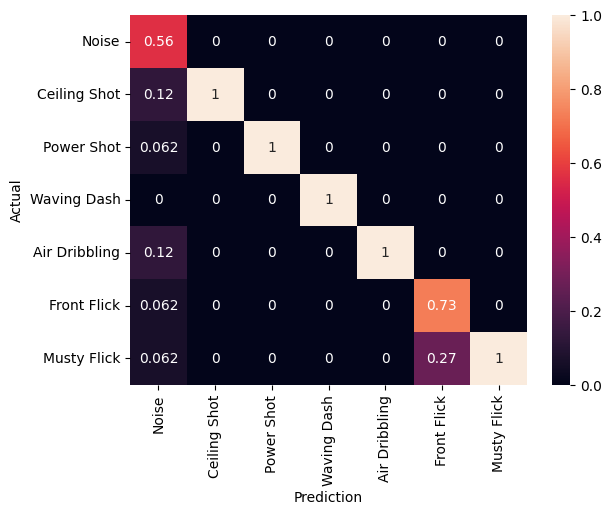

In [49]:
#getting the results
xgb_best_pred = xgb_cv_model.transform(test)
xgb_best_pred.select("prediction", 'class').show(15)
print_metrics(xgb_best_pred)

As we can see we, we achieved almost identical performances as the default model, which are still good if compared with the other models, but could still improve. Thus other round of optimizations were attempted, testing other combinations of hyperparameters, including different ones as those used in the first round (as <code>colsample_bynode</code>, <code>colsample_by_level</code>, <code>subsample</code>, DART booster...), and fixing some of them which would more likely bring good results.

All this attempts (not shown for briefness, but some of them were saved) anyway, still continued to bring the same results as the first one. After taking a quick look at all their results, it could be noticed that the best model recorded an average accuracy on the validation set around 87% and the accuracy, precison and recall on the training set were 100%. This could suggest that the model was slightly overfitting, also due to the fact that distributions of the training and the validation features are slightly different from the test one. Thus another round of optimization was added, strongly regularizing the model with the following parameters:
- Training set subsampling for each boosting round: in {0.5, 0.75}. Since the training set is already quite small, these values were deemed to be interesting as they did not reduce too much the quantity of examples used and were still far from considering the full dataset;
- Feature sample rate to be applied at each boosting round: in {0.5, 0.75}. The value "1" was removed for the reasons as before;
- Number of boosting rounds: in {10, 15, 20, 25}
- Lambda regularization term (L2): in {0.75, 1, 1.5};
- Alpha regularization term (L1): in {0.75, 1, 1.5};
- Gamma (Minimum loss delta): in {0.25, 0.5, 1};

Two parameters were fixed by looking at all the results of the previous search rounds:
- <code>max_depth</code> = 7;
- <code>learning_rate</code> = 0.1;

In [39]:
# base model
xgb_cv2 = SparkXGBClassifier(features_col='features',
                         label_col='class',
                         weight_col='weights',
                         num_workers=2,
                         verbose=0,
                         random_state=seed)
# building the grid
xgb_param_grid2 = ParamGridBuilder()\
                .baseOn({xgb_cv2.learning_rate:0.1, xgb_cv2.max_depth: 7})\
                .addGrid(xgb_cv2.subsample, [0.5, 0.75])\
                .addGrid(xgb_cv2.colsample_bytree, [0.5, 0.75])\
                .addGrid(xgb_cv2.n_estimators, [10, 15, 20, 25])\
                .addGrid(xgb_cv2.reg_lambda, [1.5, 1, 0.75])\
                .addGrid(xgb_cv2.reg_alpha, [1.5, 1, 0.75])\
                .addGrid(xgb_cv2.gamma, [1, 0.5, 0.25]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

xgb_cross_val2 = CrossValidator(estimator=xgb_cv2,
                              estimatorParamMaps=xgb_param_grid2,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)

In [ ]:
xgb_cv_model2 = xgb_cross_val2.fit(train)

Here we save the model and plot the best hyperparameters found...

In [14]:
print("Best parameters:")
print({k.name : v for (k,v) in xgb_cv_model2.getEstimatorParamMaps()[np.argmax(xgb_cv_model2.avgMetrics)].items()})

Best parameters:
{'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.75, 'colsample_bytree': 0.5, 'n_estimators': 25, 'reg_lambda': 1, 'reg_alpha': 1, 'gamma': 0.25}


In [ ]:
xgb_cv_model2.save(model_path+"xgb/hyperParameterTunedFinal")

...And the results.

2023-10-01 22:12:31,812 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       1.0|    1|
|       1.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows



2023-10-01 22:12:32,617 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2023-10-01 22:12:32,717 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Accuracy: 
0.883
Weighted precision: 
0.913
Unweighted recall: 
0.872


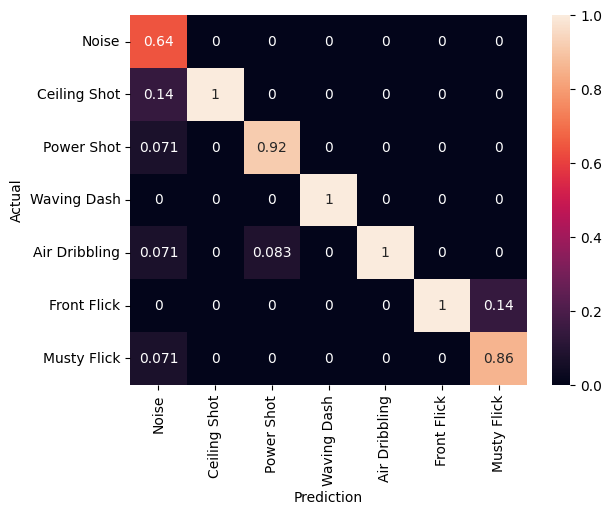

In [46]:
xgb_best_pred2 = xgb_cv_model2.transform(test)
xgb_best_pred2.select("prediction", 'class').show(15)
print_metrics(xgb_best_pred2)

With the last round of optimization, the model reached the accuracy of the Random Forest model with a ~+5% from the base model and shows a increase of ~+1.4% in precision and  ~+6.1 in recall.

The tuned model:
- Effectively classifies more precisely the "Noise" class by reducing the false positives of this class w.r.t. the base model.
- Shows a slightly less confusion on the "Front Flick" - "Musty Flick" pair of classes.
- Makes some mistakes by classifying some "Air Dribbling" examples as "Power shot" class. This are common errors among all the models for the reasons explained in the Decision Tree results analysis, but weren't present in the base model.

## SVM
SVM is the only model we apply the One-vs-Rest technique as PySpark offers only the LinearSVC as Support Vector Machine, which is a binary classifier.

In [21]:
svm = OneVsRest(classifier=LinearSVC(), featuresCol='features', labelCol='class', parallelism=2)
# fitting the model
svmf = svm.fit(train)
# saving
svmf.save(model_path+"svm/base")

+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       0.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       6.0|
|    5|       5.0|
|    5|       0.0|
|    6|       6.0|
|    6|       6.0|
|    1|       1.0|
|    1|       4.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows

Accuracy: 
0.767
Weighted precision: 
0.815
Unweighted recall: 
0.732


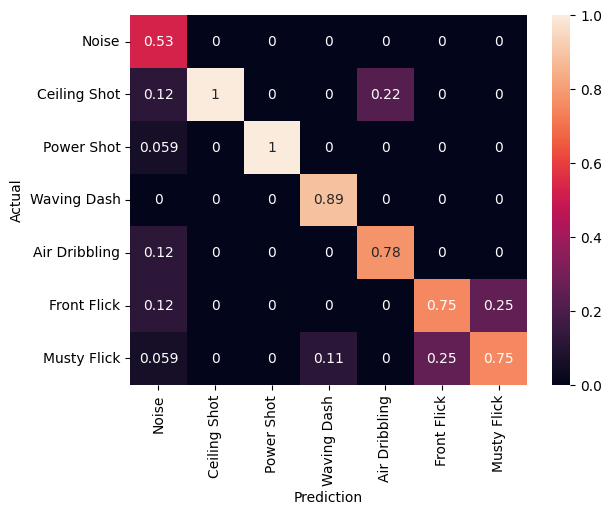

In [50]:
# getting the results
svm_predictions = svmf.transform(test)
svm_predictions.select('class', 'prediction').show(15)
print_metrics(svm_predictions)

In order to tune the LinearSVC, we choose the following hyperparameters:
- Maximum number of iterations: in {50, 100, 500};
- Regularization parameter: in {0.001, 0.01, 0.1, 1.0, 10, 100, 1000};
- Whether to fit an intercept term: True or False;
- Cpnvergence tolerance: in {1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6}.

In [7]:
# base model
svm_base = LinearSVC()
svm_cv = OneVsRest(classifier=svm_base,featuresCol='features', labelCol='class')

# building the grid
svm_param_grid = ParamGridBuilder()\
    .addGrid(svm_base.maxIter, [50,100,500 ])\
    .addGrid(svm_base.regParam, [0.001, 0.01, 0.1, 1.0, 10, 100, 1000])\
    .addGrid(svm_base.fitIntercept, [True, False])\
    .addGrid(svm_base.tol, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')
svm_cross_val = CrossValidator(estimator=svm_cv,
                              estimatorParamMaps=svm_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)


In [ ]:
svm_cv_model = svm_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [59]:
print("Best parameters:")
print({k.name : v for (k,v) in svm_cv_model.getEstimatorParamMaps()[np.argmax(svm_cv_model.avgMetrics)].items()})
svm_cv_model.save(model_path+"svm/hyperParameterTuned")

Best parameters:
{'fitIntercept': True, 'regParam': 0.1, 'tol': 0.01, 'maxIter': 50}


...And the results.

+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       6.0|    6|
|       0.0|    1|
|       1.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.817
Weighted precision: 
0.859
Unweighted recall: 
0.787


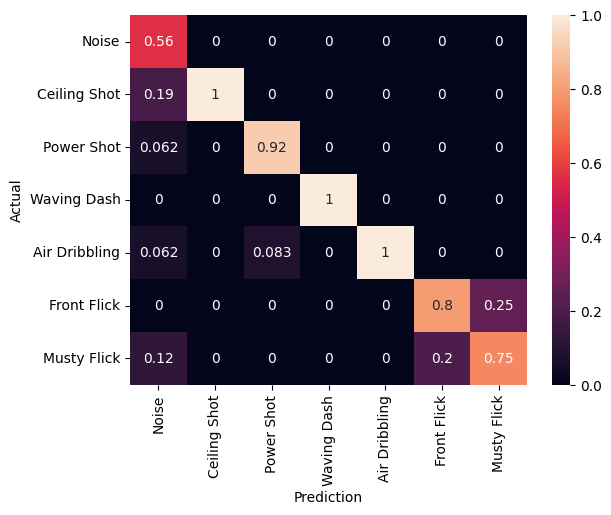

In [51]:
svm_best_pred = svm_cv_model.transform(test)
svm_best_pred.select("prediction", 'class').show(15)
print_metrics(svm_best_pred)

Also in the case of the SVM, the tuning procedure increased the overall performance of the model, improving by ~+5% the accuracy, by ~+4.4% the precision and by ~+5.5% the recall.

Looking ad the confusion matrix, we see that:
- This model in its tuned form improves on the "Waving Dash", "Front Flick" and "Ceiling Shot" predictions;
- Both models still show some confusion on the "Front Flick" and "Musty Flick" classes due to their similarity;
- The tuned model tends to commit more errors in classfying the examples as "Noise" rather than considering similar classes as done by the base model.

## Naive Bayes

In [12]:
nb = NaiveBayes(featuresCol='features', labelCol='class', smoothing=1e-9,
               modelType='gaussian')
# fitting the model
nbf = nb.fit(train)
# saving
nbf.save(model_path+"nb/base")


+-----+----------+
|class|prediction|
+-----+----------+
|    4|       4.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       5.0|
|    5|       2.0|
|    5|       6.0|
|    5|       5.0|
|    5|       5.0|
|    6|       6.0|
|    6|       0.0|
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 15 rows

Accuracy: 
0.667
Weighted precision: 
0.742
Unweighted recall: 
0.661


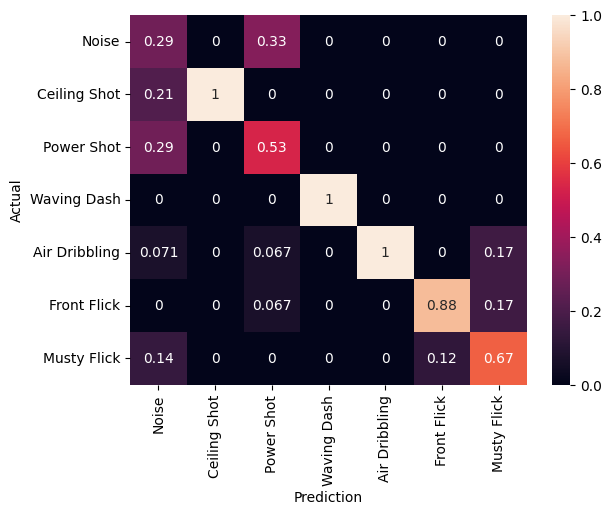

In [52]:
# getting the predictions
nb_predictions = nbf.transform(test)
nb_predictions.select('class', 'prediction').show(15)
print_metrics(nb_predictions)

The hyperparameter space of the Naive Bayes classifier is quite narrow, as it has only two parameters that can be reasonably tuned:
- Label smoothing: in {1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9};
- Type of the model: between multinomial, gaussian or bernoulli. We still try all the models, even if the "bernoulli" model should be enough to handle binary features.

In [17]:
# base model
nb_cv = NaiveBayes(featuresCol='features', labelCol='class')

# building the grid
nb_param_grid = ParamGridBuilder()\
    .addGrid(nb_cv.smoothing, [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9])\
    .addGrid(nb_cv.modelType, ['multinomial','gaussian', 'bernoulli']).build()

# accuracy-based evaluation for the cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol='prediction', metricName='accuracy')

nb_cross_val = CrossValidator(estimator=nb_cv,
                              estimatorParamMaps=nb_param_grid,
                              evaluator=evaluator,
                              numFolds=4,
                              parallelism=2,
                              seed=seed)

In [ ]:
nb_cv_model = nb_cross_val.fit(train)

Here we save the model and plot the best hyperparameters found...

In [63]:
print("Best parameters:")
print({k.name : v for (k,v) in nb_cv_model.getEstimatorParamMaps()[np.argmax(nb_cv_model.avgMetrics)].items()})
nb_cv_model.save(model_path+"nb/hyperParameterTuned")

Best parameters:
{'modelType': 'bernoulli', 'smoothing': 0.01}


...And the results.

23/10/01 22:19:16 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/01 22:19:16 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
+----------+-----+
|prediction|class|
+----------+-----+
|       4.0|    4|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    5|
|       5.0|    5|
|       5.0|    5|
|       6.0|    6|
|       0.0|    6|
|       1.0|    1|
|       0.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 15 rows

Accuracy: 
0.783
Weighted precision: 
0.820
Unweighted recall: 
0.756


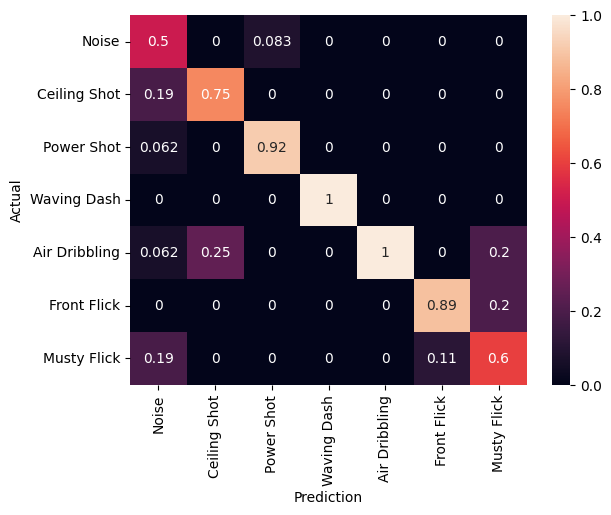

In [53]:
nb_best_pred = nb_cv_model.transform(test)
nb_best_pred.select("prediction", 'class').show(15)
print_metrics(nb_best_pred)

The Naive Bayes classifier is reconfirmed to be the less promising when compared to the others as it starts from a really low base performance. The Tuned version improves a lot on this, showing ~+11.6% on accuracy, ~+7.8% on precision and ~+9.5%.

We can see that:
- The base model commits most of the errors in classifying the "Noise" as "Power Shot".
- Both models tend to classify classes wrongly as "Nois"e (even if less in the tuned one) and to show some confusion on similar classes like "Front Flick" and "Musty Flick" and "Ceiling Shot" and "Air Dribbling".

## Summary of the results, final comments and possible future developments
Before presenting the summarization of the results, we add two cells: one to generate the predictions in case the models have been loaded and the other to generate the metrics to be displayed.

In [55]:
# generate predictions if the models have been loaded
dtc_predictions = dtcf.transform(test)
rfc_predictions = rfcf.transform(test)
xgb_predictions = xgbf.transform(test)
svm_predictions = svmf.transform(test)
nb_predictions = nbf.transform(test)

dtc_best_pred = dtc_cv_model.transform(test)
rfc_best_pred = rfc_cv_model.transform(test)
xgb_best_pred = xgb_cv_model.transform(test)
svm_best_pred = svm_cv_model.transform(test)
nb_best_pred = nb_cv_model.transform(test)

In [ ]:
# generate metrics
dtc_metrics = compute_metrics(dtc_predictions)
rfc_metrics = compute_metrics(rfc_predictions)
xgb_metrics = compute_metrics(xgb_predictions)
svm_metrics = compute_metrics(svm_predictions)
nb_metrics = compute_metrics(nb_predictions)

dtc_best_metrics = compute_metrics(dtc_best_pred)
rfc_best_metrics = compute_metrics(rfc_best_pred)
xgb_best_metrics = compute_metrics(xgb_best_pred)
svm_best_metrics = compute_metrics(svm_best_pred)
nb_best_metrics = compute_metrics(nb_best_pred)

We then show the plots summarizing barplots showing side-to-side accuracy, weighted precision and recall for each model, before and after tuning. We also show the results reported in the paper to make a comparison.

------------------- Results reported in the paper -------------------


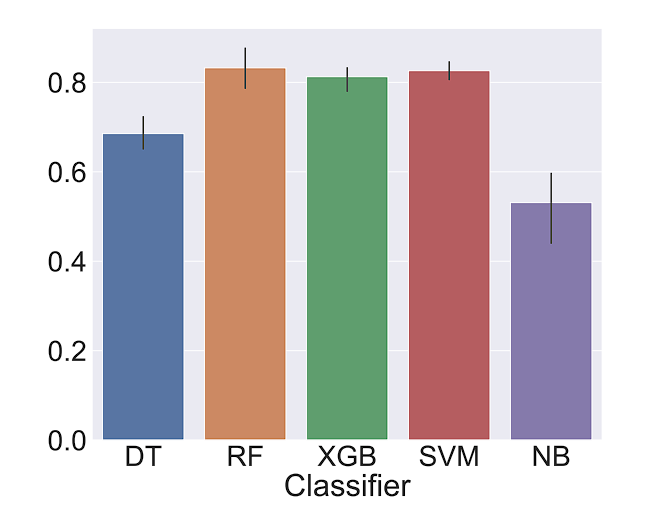

In [63]:
print("------------------- Results reported in the paper -------------------")
Image(filename='paper_results.png') 

In [57]:
model_names = ['DT', 'RF', 'XGB', 'SVM', 'NB']
final_metrics = [dtc_metrics, rfc_metrics, xgb_metrics, svm_metrics, nb_metrics]
improved_metrics = [dtc_best_metrics, rfc_best_metrics, xgb_best_metrics, svm_best_metrics, nb_best_metrics]
# width is used to control the width of the bars in the following plots
width=0.25

23/10/01 22:26:26 WARN DAGScheduler: Broadcasting large task binary with size 1403.3 KiB


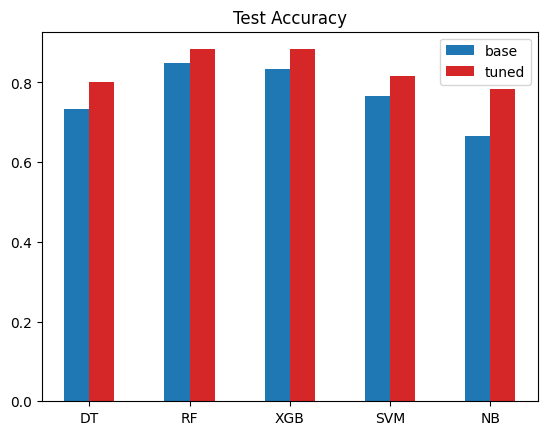

In [58]:
plt.title("Test Accuracy")
# plotting final accuracy in blue
plt.bar(np.arange(len(model_names)),
        [i.accuracy for i in final_metrics],
        color='tab:blue', label='base',
       width=width)
# plotting improved accuracy in red
plt.bar(np.arange(len(model_names))+width,
        [i.accuracy for i in improved_metrics],
        color='tab:red', label="tuned",
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()

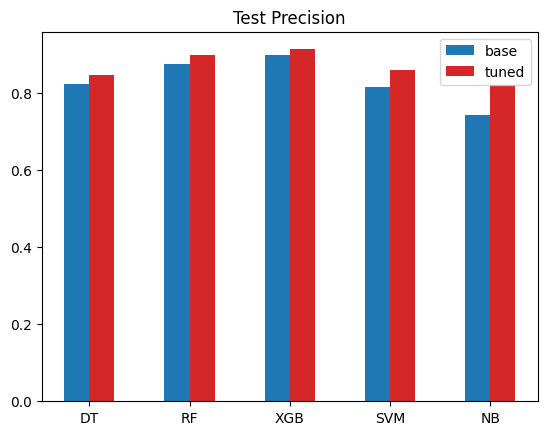

In [59]:
plt.title("Test Precision")
# plotting final precision in blue
plt.bar(np.arange(len(model_names)),
        [i.weightedPrecision for i in final_metrics],
        color='tab:blue', label='base',
       width=width)
# plotting improved precision in red
plt.bar(np.arange(len(model_names))+width,
        [i.weightedPrecision for i in improved_metrics],
        color='tab:red', label="tuned",
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()

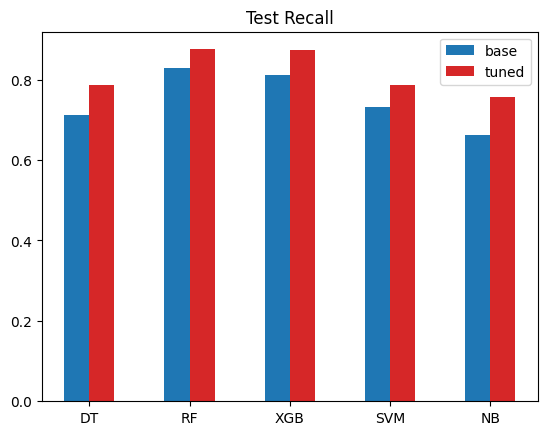

In [60]:
plt.title("Test Recall")
# plotting final recall in blue
plt.bar(np.arange(len(model_names)),
        [compute_mean_recall(i) for i in final_metrics],
        color='tab:blue', label="base",
       width=width)
# plotting improved recall in red
plt.bar(np.arange(len(model_names))+width,
        [compute_mean_recall(i) for i in improved_metrics],
        color='tab:red', label='tuned',
       width=width)
plt.xticks(np.arange(len(model_names))+width/2, model_names)
plt.legend()
plt.show()

First of all, we can consider that, at least for the base models, we have achieved results comparables to those of the paper, even considered the differences in implementation. The SVM is the only model that records slightly lower values due to the simplicity of the LinearSVC when compared with the non-linear one. However, the comparability of the results, together with the preliminary data analysis at the beginning of this notebook, confirms the correctness of the implementation and the execution of the *Seq Scout* algorithm in a distributed environment.

Then, we can see that all the models have improved over all the metrics, with the Naive Bayes recording the highest improvement. This can be easily explained as both the default model and the one used by the paper are Gaussian Naive Bayes classifiers, which are designed to handle continuous data rather than the binary features we have in our dataset. Thus, using a more appropriate base model is enough to remarkably improve the results. Still, the Naive Bayes classifier falls behind the others in terms of performances probably because it lacks in capturing the correlations between features due to the independency assumption on them. In fact, as we have seen with the analysis on the encoded datasets and from the confusion matrices, even if the pattern mining algorithm can correctly extract discriminative patterns, some of them may still appear in examples from other classes. It follows that the ability of the model to capture correlations between the features may be fundamental to avoid errors.

Following from the comparability of the results, we can also state that the models returning the most promising results are still the XGBoost and the Random Forest (reaching 88% accuracy), with the latter having a slightly higher base performance while the former records a slightly higher precision when tuned. This improvement, however came at the cost of a more intensive Hyper-parameter search, due to the tendency of the XGBoost model to overfit. This tendency may come, not only from the slight difference in feature distribution between training and test split, but also from the fact that the training set may be too small for such a complex algorithm. 

In summa, we can state that even if the correct implementation and tuning of the *Seq Scout* algorithm is of paramount importance, we can consistently improve the performances of the Machine Learning models exploiting its outputs through a simple hyper-parameter search. In this way, even a simpler model as a Decision Tree or a small Random Forest could be a viable solution to solve the classification problem at hand. This work, however, still presents some challenges for future contributions:
- Replicate the procedure on a larger dataset to fully exploit the capacities of the distributed environment offered by Hadoop+PySpark as well as of more complex models as the XGBoost.
- Test other models, either more complex (as a small Neural Network) or simpler (as a KNN classifier) to check if there are different possible solutions.
- Replicate the results by running the pattern mining procedure as well as the learning and tuning ones on different combinations of train + test splits to obtain more statistically accurate metrics.